In [1]:
# Required packages for this notebook. Uncomment and run to install.
# pip install keras scikit-learn tensorflow tqdm matplotlib numpy pandas seaborn

# Imports

In [1]:
from __future__ import annotations
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping 
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tqdm.keras import TqdmCallback
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

2025-06-19 07:57:30.093558: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-19 07:57:30.286913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-19 07:57:30.383992: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-19 07:57:30.413924: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-19 07:57:30.577652: I tensorflow/core/platform/cpu_feature_guar

# Functions

In [2]:
def make_model(x_train:pd.DataFrame,
               y_train:pd.DataFrame,
               layers:list[int,str],
               val_data:tuple(pd.DataFrame,pd.DataFrame) | val_data=0.2,
               loss_fn:str | loss_fn='categorical_crossentropy',
               output:str | output="softmax",
               lr:float | lr=0.005,
               epochs:int | epochs=400,
               batch:int | batch=400,
               seed:int | seed=None) -> list[keras.Sequential,keras.src.callbacks.history.History]:
    """
    Creates a NN model, trains it, and returns the model with training history
    x_train:  x tarining data
    y_train:  y training data
    layers:   model structure
    val_set:  Validation set (x,y)
    loss_fn:  loss funtion to use
    output:   activation function of the output layer
    lr:       learning rate
    epochs:   number of epochs
    batch:    batch size
    seed:     random seed to use
    """
    if seed is not None:
        keras.utils.set_random_seed(seed)
    # MAKE
    model = Sequential()
    model.add(keras.Input(shape=(x_train.shape[1],)))
    for l in layers:
        model.add(Dense(l[0], activation=l[1])) #'linear' 'relu', 'exponential', 'sigmoid', 'tanh'
    model.add(Dense(y_train.shape[1], activation=output))
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer= opt, loss=loss_fn, metrics=['accuracy'])

    # FIT
    if type(val_data) == float:
        history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch, validation_split=val_data, shuffle=False, verbose=0, callbacks=[TqdmCallback(verbose=1)])#, class_weight={0:2,1:2,2:2,3:2,4:1,5:1})
    else:
        history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch, validation_data=val_data, shuffle=False, verbose=0, callbacks=[TqdmCallback(verbose=1)])
    return model,history

def trends(histories:list[keras.src.callbacks.history.History],
           title:str | title=None) -> None:
    """
    Plots the ANN model training loss and accuracy from the history returned by the make_model function
    histories:    list of histories of ANN models
    title:        Title for the generated plot
    """
    acc_list = [history.history['accuracy'] for history in histories]
    val_acc_list = [history.history['val_accuracy'] for history in histories]
    loss_list = [history.history['loss'] for history in histories]
    val_loss_list = [history.history['val_loss'] for history in histories]
    epochs = [len(loss) for loss in loss_list]
    epochs = range(1, sum(epochs) + 1)

    acc = np.concatenate(acc_list)
    val_acc = np.concatenate(val_acc_list)
    loss = np.concatenate(loss_list)
    val_loss = np.concatenate(val_loss_list)
    
    plt.rc("font", family="serif")
    plt.plot(epochs, acc, "black", label="Training accuracy", linestyle="dashed")
    plt.plot(epochs, val_acc, "blue", label="Validation accuracy", linestyle="dotted")
    plt.plot(epochs, loss, "orange", label="Training loss", linestyle="dashdot")
    plt.plot(epochs, val_loss, "red", label="Validation loss")

    if title is not None:
        plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy and Loss")
    plt.legend()
    plt.grid()
    plt.show()

def confusion(model:keras.models,
              x:pd.DataFrame,
              y:pd.DataFrame,
              y_names:str | y_names=None,
              title:str | title="Test") -> None:
    """
    Plots a confusion matrix given ANN model and the x,y data.
    model:    trained keras model
    x:        x-data
    y:        y-data
    y_names:  names of the two classes for a binary output model
    name:     Title for the confustion matrix plot
    """
    if len(y.columns) == 1:
        predictions = np.round(model.predict(x),0)
        if y_names == None:
            raise ValueError("y_names need to be provided for single output models")
        predictions = np.where(predictions==1,[0,1],[1,0])
        pred_list = predictions.tolist()
        pred_df = pd.DataFrame(pred_list, columns = ["PRED_"+i for i in y_names])
        T5_lables_1 = y_names
        y = np.where(y==1,[0,1],[1,0])
    else:
        predictions = np.round(model.predict(x),2)
        pred_list = predictions.tolist()
        pred_df = pd.DataFrame(pred_list, columns = ["PRED_"+i for i in (y.columns)])
        T5_lables_1 = list(y.columns)
    
    ax = plt.subplot()
    plt.rc("font", family="serif")
    cm = confusion_matrix(np.asarray(y).argmax(axis=1), np.asarray(predictions).argmax(axis=1))
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    
    # labels, title and ticks
    ax.set_xlabel("Predicted labels");
    ax.set_ylabel("True labels"); 
    ax.set_title(f"Confusion Matrix ({title})"); 
    ax.xaxis.set_ticklabels(T5_lables_1);
    ax.yaxis.set_ticklabels(T5_lables_1);
    plt.show()

def report(model:keras.models,
           x:pd.DataFrame,
           y:pd.DataFrame,
           y_names:str | y_names=None) -> sklearn.metrics.classification_report:

    """
    Generates a classification report for the given model and x,y data.
    model:    trained keras model
    x:        x-data
    y:        y-data
    y_names:  names of the two classes for a binary output model
    """
    print("Accuracy:")
    print(model.evaluate(x,y))
    if len(y.columns) == 1:
        predictions = np.round(model.predict(x),0)
        if y_names == None:
            raise ValueError("y_names need to be provided for single output models")
        predictions = np.where(predictions==1,[0,1],[1,0])
        y = np.where(y==1,[0,1],[1,0])
        target_names = y_names
    else:
        predictions = np.round(model.predict(x),3)
        target_names = list(y.columns)
    return classification_report(np.argmax(y,axis=1), np.argmax(predictions,axis=1), target_names=target_names)

# SLOCC Classification

## Import Datasets
Import the training and testing dataset exported by the <b> 1. Data and Features</b> notebook. <br>
Format the data by removing unnecessary columns for SLOCC Classification

In [3]:
# Train
df_train = pd.read_csv("test_train_data/train.csv",index_col=0)
# Test
df_test = pd.read_csv("test_train_data/test.csv",index_col=0)

# Using all 63 density matrix elements
x_train_63 = df_train.iloc[:,:63]
y_train = df_train.iloc[:,63:]
y_train = y_train.drop(["CODE"],axis=1) # Not needed for this classification

x_test_63 = df_test.iloc[:,:63]
y_test = df_test.iloc[:,63:]
y_test = y_test.drop(["CODE"],axis=1) # Not needed for this classification

# Using only 7 diagonal density matrix elements
features = ["Rho_0_0_Real","Rho_1_1_Real","Rho_2_2_Real","Rho_3_3_Real","Rho_4_4_Real","Rho_5_5_Real","Rho_6_6_Real"]
x_train_7 = x_train_63[features]
x_test_7 = x_test_63[features]

## Model Training and Evaluation
Train, evaluate and save ANN model for the SLOCC Classification task

### Using all 63 features

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

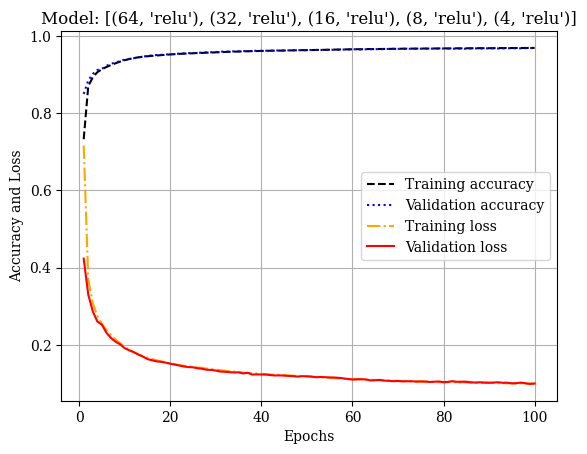

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step


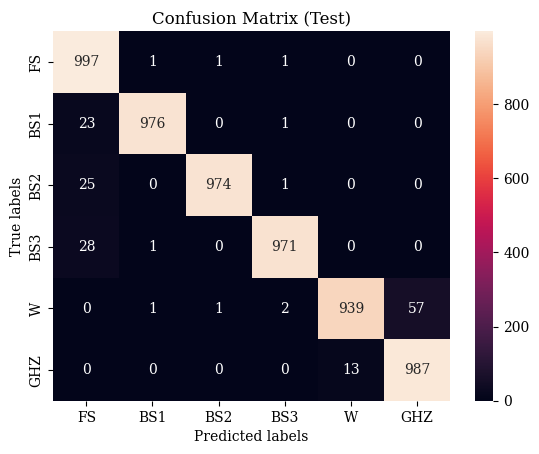

Test Data Report:
Accuracy:
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - accuracy: 0.9729 - loss: 0.0850
[0.08511430770158768, 0.9738333225250244]
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
              precision    recall  f1-score   support

          FS       0.93      1.00      0.96      1000
         BS1       1.00      0.98      0.99      1000
         BS2       1.00      0.97      0.99      1000
         BS3       0.99      0.97      0.98      1000
           W       0.99      0.94      0.96      1000
         GHZ       0.94      0.99      0.97      1000

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000



In [4]:
# Make
act = 'relu'
model_structure = [(64,act),(32,act),(16,act),(8,act),(4,act)]
model,history = make_model(x_train_63,y_train,model_structure,val_data=0.2,epochs=100,batch=5000,lr=0.0025)

# Plots
trends([history],f"Model: {model_structure}")

# Confusion Matrix
confusion(model,x_test_63,y_test,"Test Data")

# Report
print("="*30,"\nTest Data Report:")
print(report(model,x_test_63,y_test))

# Save the model (uncomment to save the new model)
#model.save("trained_models/slocc_63f.keras")

### Using only 7 diagonal elements

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

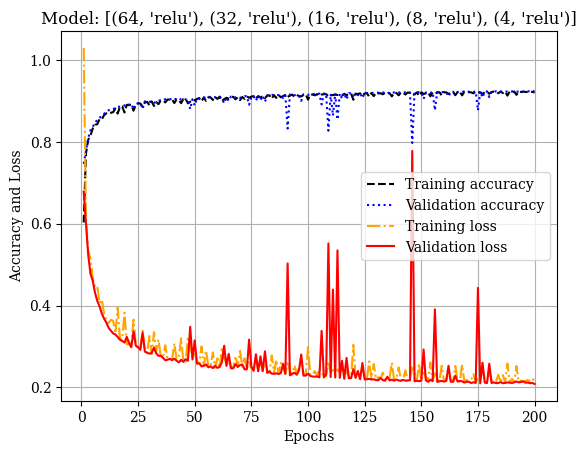

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step


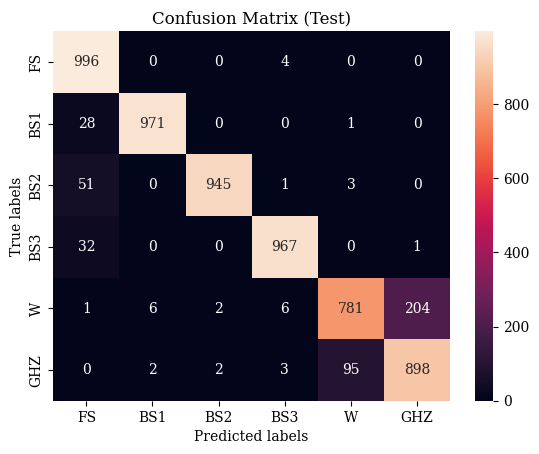

Test Data Report:
Accuracy:
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.9289 - loss: 0.2000
[0.21032844483852386, 0.9261666536331177]
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step
              precision    recall  f1-score   support

          FS       0.90      1.00      0.95      1000
         BS1       0.99      0.97      0.98      1000
         BS2       1.00      0.94      0.97      1000
         BS3       0.99      0.97      0.98      1000
           W       0.89      0.78      0.83      1000
         GHZ       0.81      0.90      0.85      1000

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000



In [5]:
# Make
model_structure = [(64,'relu'),(32,'relu'),(16,'relu'),(8,'relu'),(4,'relu')]
model,history = make_model(x_train_7,y_train,model_structure,val_data=0.2,epochs=200,batch=5000,lr=0.0025)

# Plots
trends([history],f"Model: {model_structure}")

# Confusion Matrix
confusion(model,x_test_7,y_test,"Test Data")

# Report
print("="*30,"\nTest Data Report:")
print(report(model,x_test_7,y_test))

# Save the model
#model.save("trained_models/slocc_7f.keras")

# GME Classification

## Import Datasets
Import the training and testing dataset exported by the <b> 1. Data and Features</b> notebook. <br>
Format the data by as needed for GME Classification

In [21]:
# Train
df_train = pd.read_csv("test_train_data/train.csv",index_col=0)
df_train['GME'] = np.where((df_train['CODE']>=4),1,0) # CODE = [4,5] are W and GHZ classes. This creates a GME column with value 1 for these classes and 0 otherwise
# Test
df_test = pd.read_csv("test_train_data/test.csv",index_col=0)
df_test['GME'] = np.where((df_test['CODE']>=4),1,0) # CODE = [4,5] are W and GHZ classes. This creates a GME column with value 1 for these classes and 0 otherwise


# Using all 63 density matrix elements
x_train_63 = df_train.iloc[:,:63]
y_train = df_train[['GME']] # Only need the GME column as label

x_test_63 = df_test.iloc[:,:63]
y_test = df_test[['GME']] # Only need the GME column as label

# Using only 7 diagonal density matrix elements
features = ["Rho_0_0_Real","Rho_1_1_Real","Rho_2_2_Real","Rho_3_3_Real","Rho_4_4_Real","Rho_5_5_Real","Rho_6_6_Real"]
x_train_7 = x_train_63[features]
x_test_7 = x_test_63[features]

## Model Training and Evaluation
Train, evaluate and save ANN model for the GME Classification task

### Using all 63 features

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

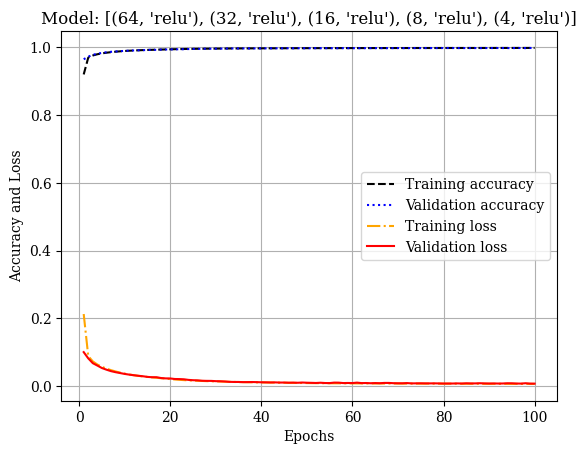

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


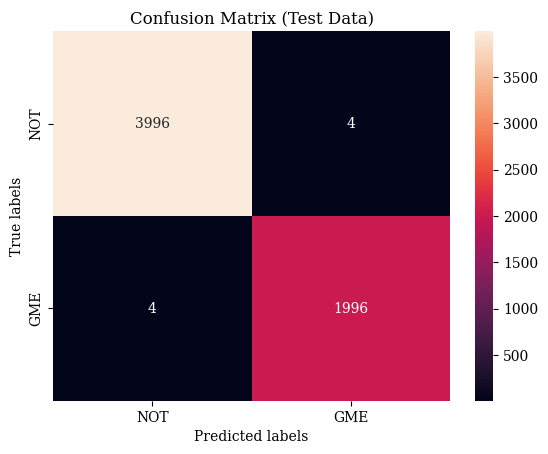

Test Data Report:
Accuracy:
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - accuracy: 0.9981 - loss: 0.0053
[0.00435035303235054, 0.9986666440963745]
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step
              precision    recall  f1-score   support

         NOT       1.00      1.00      1.00      4000
         GME       1.00      1.00      1.00      2000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



In [26]:
# Make
act = 'relu'
model_structure = [(64,act),(32,act),(16,act),(8,act),(4,act)]
model,history = make_model(x_train_63,y_train,model_structure,loss_fn="binary_crossentropy",output="sigmoid",val_data=0.2,epochs=100,batch=5000,lr=0.0025)

# Plots
trends([history],f"Model: {model_structure}")

# Confusion Matrix
confusion(model,x_test_63,y_test,y_names=["NOT","GME"],title="Test Data")

# Report
print("="*30,"\nTest Data Report:")
print(report(model,x_test_63,y_test,y_names=["NOT","GME"]))

# Save the model
#model.save("trained_models/gme_63f.keras")

### Using only 7 diagonal elements

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

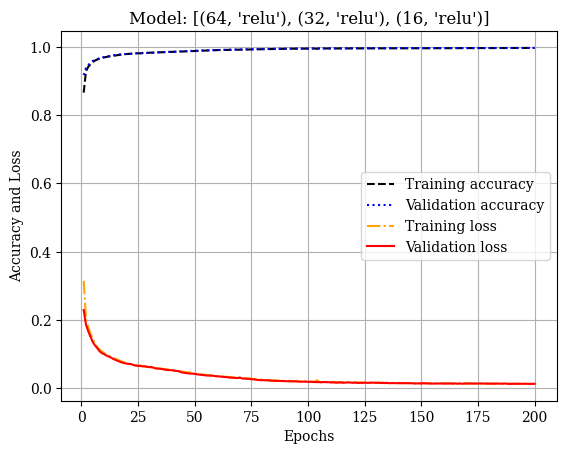

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


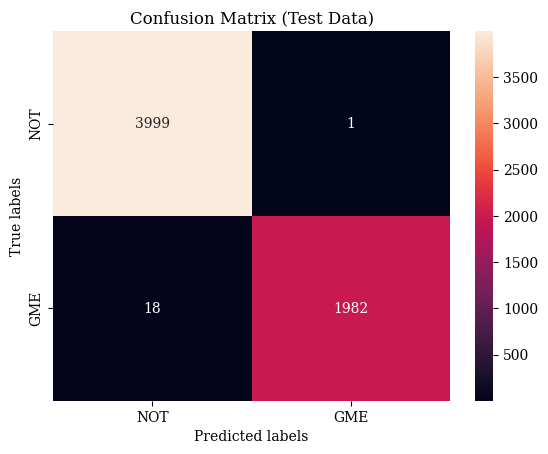

Test Data Report:
Accuracy:
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step - accuracy: 0.9980 - loss: 0.0077
[0.012992792762815952, 0.996833324432373]
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 175us/step
              precision    recall  f1-score   support

         NOT       1.00      1.00      1.00      4000
         GME       1.00      0.99      1.00      2000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



In [27]:
# Make
model_structure = [(64,act),(32,act),(16,act)]
model,history = make_model(x_train_7,y_train,model_structure,loss_fn="binary_crossentropy",output="sigmoid",val_data=0.2,epochs=200,batch=5000,lr=0.0025)

# Plots
trends([history],f"Model: {model_structure}")

# Confusion Matrix
confusion(model,x_test_7,y_test,y_names=["NOT","GME"],title="Test Data")

# Report
print("="*30,"\nTest Data Report:")
print(report(model,x_test_7,y_test,y_names=["NOT","GME"]))

# Save the model
#model.save("trained_models/gme_7f.keras")

# Hierarchical Network SLOCC Classification

## Import Datasets
Import individual datasets exported by the <b> 1. Data and Features</b> notebook. <br>
Create training dataset for each hierarchical model using these <br>
Import hierarchical test datasets exported by the <b> 1. Data and Features</b> notebook.

In [28]:
class_dictionary = {0:'SEP',1:'BS1',2:'BS2',3:'BS3',4:'W',5:'GHZ'}
dfs = {}
for data_number in range(6):
    dfs[data_number] = pd.read_csv(f"test_train_data/individual_classes/{class_dictionary[data_number]}.csv",index_col=0)

# Train
features = ["Rho_0_0_Real","Rho_1_1_Real","Rho_2_2_Real","Rho_3_3_Real","Rho_4_4_Real","Rho_5_5_Real","Rho_6_6_Real"]
n_features = len(features)
n_states = dfs[0].shape[0]

#################################
# FS-NOT
#################################
class_contibution = n_states//5
# Train
df_list = [dfs[0]]
for i in range(1,6):
    df_list.append(dfs[i].iloc[:class_contibution])
df = pd.concat(df_list,ignore_index=True)
df["NOT"] = np.where((df["CODE"]>0),1,0)
df = df.sample(frac=1).reset_index(drop=True)
x_train_fs = df[features]
y_train_fs = df[["FS"]]

# Test
df = pd.read_csv("test_train_data/hierarchical/test_fs.csv",index_col=0)
x_test_fs = df[features]
y_test_fs = df[["FS"]]

#################################
# BS-GME
#################################
class_contibution = n_states//2
# Train
df_list = [dfs[1],dfs[2],dfs[3]]
for i in range(4,6):
    df_list.append(dfs[i].iloc[:class_contibution])
df = pd.concat(df_list,ignore_index=True)
df["GME"] = np.where((df["CODE"]>3),1,0)
df = df.sample(frac=1).reset_index(drop=True)
x_train_bs_gme = df[features]
y_train_bs_gme = df[["BS1","BS2","BS3","GME"]]

# Test
df = pd.read_csv("test_train_data/hierarchical/test_bs_gme.csv",index_col=0)
x_test_bs_gme = df[features]
y_test_bs_gme = df[["BS1","BS2","BS3","GME"]]

#################################
# W-GHZ
#################################
# Train
df = pd.concat([dfs[4],dfs[5]],ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
x_train_w_ghz = df[features]
y_train_w_ghz = df[["GHZ"]]

# Test
df = pd.read_csv("test_train_data/hierarchical/test_w_ghz.csv",index_col=0)
x_test_w_ghz = df[features]
y_test_w_ghz = df[["GHZ"]]


#################################
# Final Combined Model Test
#################################
# Test
df = pd.read_csv("test_train_data/hierarchical/test_final.csv",index_col=0)
df = df[features+["FS","BS1","BS2","BS3","W","GHZ"]]
x_test = df.iloc[:,:7]
y_test = df.iloc[:,7:]

## Model Training and Evaluation
Train, evaluate and save Hierarchical ANN models for the SLOCC Classification task

### FS-NOT

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

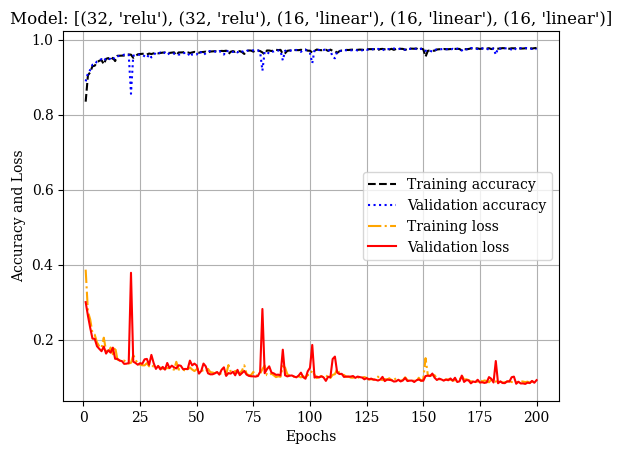

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step


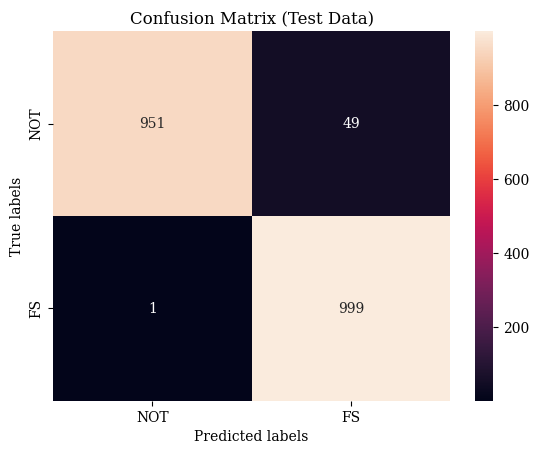

Test Data Report:
Accuracy:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step - accuracy: 0.9808 - loss: 0.0720
[0.08540504425764084, 0.9750000238418579]
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step
              precision    recall  f1-score   support

         NOT       1.00      0.95      0.97      1000
          FS       0.95      1.00      0.98      1000

    accuracy                           0.97      2000
   macro avg       0.98      0.97      0.97      2000
weighted avg       0.98      0.97      0.97      2000



In [29]:
# Make                   
model_structure = [(32,'relu'),(32,'relu'),(16,'linear'),(16,'linear'),(16,'linear')]
fs_model,fs_history = make_model(x_train_fs,y_train_fs,model_structure,val_data=0.2,epochs=200,batch=5000,lr=0.0025,loss_fn="binary_crossentropy",output="sigmoid")

# Plots
trends([fs_history],f"Model: {model_structure}")

# Confusion Matrix
confusion(fs_model,x_test_fs,y_test_fs,["NOT","FS"],"Test Data")

# Report
print("="*30,"\nTest Data Report:")
print(report(fs_model,x_test_fs,y_test_fs,["NOT","FS"]))

# Save the model
#fs_model.save("trained_models/slocc_7f_fsnot.keras")

### BS-GME

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

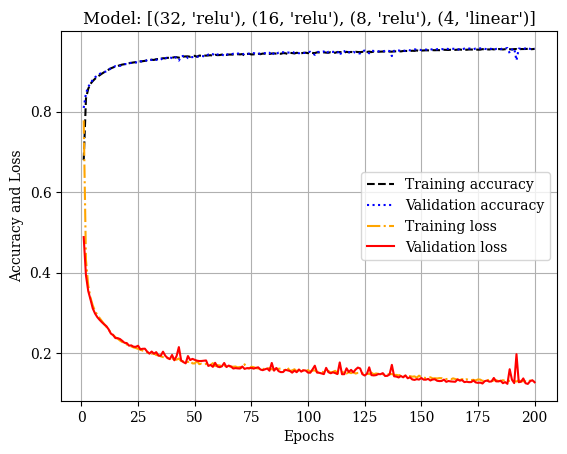

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


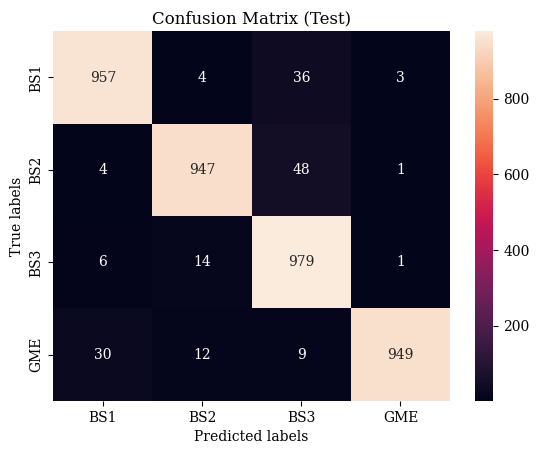

Test Data Report:
Accuracy:
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - accuracy: 0.9608 - loss: 0.1112
[0.1189970150589943, 0.9585000276565552]
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
              precision    recall  f1-score   support

         BS1       0.96      0.96      0.96      1000
         BS2       0.97      0.95      0.96      1000
         BS3       0.91      0.98      0.95      1000
         GME       0.99      0.95      0.97      1000

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



In [30]:
# Make
model_structure = [(32,'relu'),(16,'relu'),(8,'relu'),(4,'linear')]
bs_gme_model,bs_gme_history = make_model(x_train_bs_gme,y_train_bs_gme,model_structure,val_data=0.2,epochs=200,batch=5000,lr=0.0025)

# Plots
trends([bs_gme_history],f"Model: {model_structure}")

# Confusion Matrix
confusion(bs_gme_model,x_test_bs_gme,y_test_bs_gme,"Test Data")

# Report
print("="*30,"\nTest Data Report:")
print(report(bs_gme_model,x_test_bs_gme,y_test_bs_gme))

# Save the model
#bs_gme_model.save("trained_models/slocc_7f_bs_gme.keras")

### W-GHZ

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

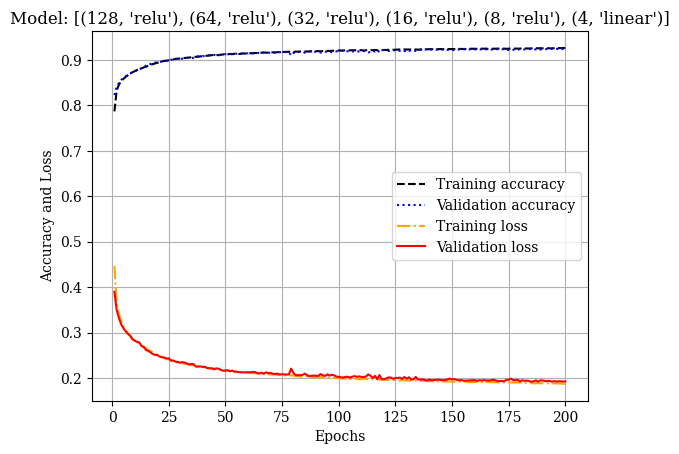

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


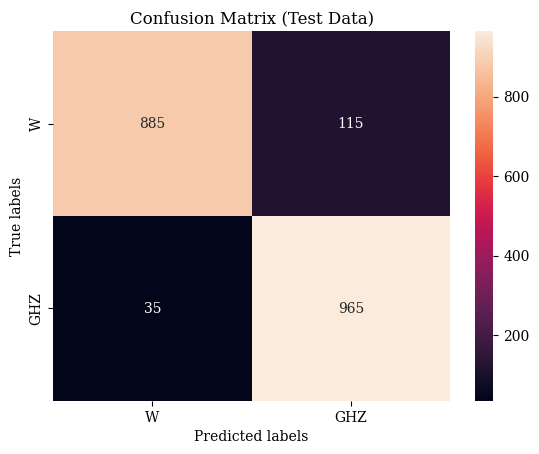

Test Data Report:
Accuracy:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - accuracy: 0.9273 - loss: 0.1854
[0.18497700989246368, 0.925000011920929]
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
              precision    recall  f1-score   support

           W       0.96      0.89      0.92      1000
         GHZ       0.89      0.96      0.93      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.92      2000
weighted avg       0.93      0.93      0.92      2000



In [31]:
# Make
model_structure = [(128,'relu'),(64,'relu'),(32,'relu'),(16,'relu'),(8,'relu'),(4,'linear')]
w_ghz_model,w_ghz_history = make_model(x_train_w_ghz,y_train_w_ghz,model_structure,val_data=0.2,epochs=200,batch=5000,lr=0.005,loss_fn="binary_crossentropy",output="sigmoid")

# Plots
trends([w_ghz_history],f"Model: {model_structure}")

# Confusion Matrix
confusion(w_ghz_model,x_test_w_ghz,y_test_w_ghz,["W","GHZ"],"Test Data")

# Report
print("="*30,"\nTest Data Report:")
print(report(w_ghz_model,x_test_w_ghz,y_test_w_ghz,["W","GHZ"]))

# Save the model
#w_ghz_model.save("trained_models/slocc_7f_w_ghz.keras")

### Complete Model Accuracy Check
Compute the overall accuracy on the test set (of SLOCC Classification) by combining the predictions of the 3 models

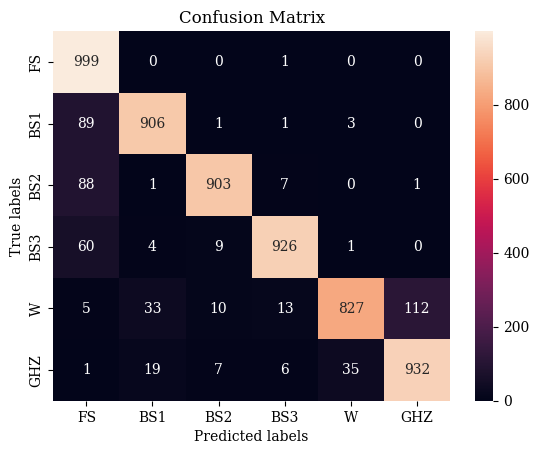

              precision    recall  f1-score   support

          FS       0.80      1.00      0.89      1000
         BS1       0.94      0.91      0.92      1000
         BS2       0.97      0.90      0.94      1000
         BS3       0.97      0.93      0.95      1000
           W       0.95      0.83      0.89      1000
         GHZ       0.89      0.93      0.91      1000

    accuracy                           0.92      6000
   macro avg       0.92      0.92      0.92      6000
weighted avg       0.92      0.92      0.92      6000



In [32]:
fs_out = np.round(fs_model.predict(x_test,verbose=0),0)
predictions = np.where(fs_out==1,[0,1],[1,0])
fs_or_not = np.argmax(predictions,axis=1)
gme = np.argmax(bs_gme_model.predict(x_test,verbose=0),axis=1)
w_ghz_out = np.round(w_ghz_model.predict(x_test,verbose=0),0)
predictions = np.where(w_ghz_out==1,[0,1],[1,0])
ghz_or_w = np.argmax(predictions,axis=1)
final_classes = np.where(fs_or_not==0,np.where(gme==3,np.where(ghz_or_w==0,4,5),gme+1),0)
predictions = keras.utils.to_categorical(final_classes,num_classes=6)

pred_list = predictions
pred_df = pd.DataFrame(pred_list, columns = ["PRED_"+i for i in (y_test.columns)])

T5_lables_1 = list(y_test.columns)
ax= plt.subplot()
plt.rc("font", family="serif")
cm = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(predictions).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel("Predicted labels");
ax.set_ylabel("True labels"); 
ax.set_title(f"Confusion Matrix"); 
ax.xaxis.set_ticklabels(T5_lables_1);
ax.yaxis.set_ticklabels(T5_lables_1);
plt.show()

print(classification_report(np.argmax(y_test,axis=1), np.argmax(predictions,axis=1), target_names=list(y_test.columns)))